In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Data Spliting

## Training Set

In [2]:
train_set = image_dataset_from_directory(
    "dataset/",
    labels="inferred",
    label_mode="categorical",
    class_names=["Negative", "Positive"],
    image_size=(64, 64),
    shuffle=True,
    seed=1,
    subset="training",
    validation_split=0.2
)

Found 40000 files belonging to 2 classes.
Using 32000 files for training.


## Testing Set

In [3]:
test_set = image_dataset_from_directory(
    "dataset/",
    labels="inferred",
    label_mode="categorical",
    class_names=["Negative", "Positive"],
    image_size=(64, 64),
    shuffle=True,
    seed=1,
    subset="validation",
    validation_split=0.2
)


Found 40000 files belonging to 2 classes.
Using 8000 files for validation.


### Kelas yang digunakan

In [4]:
classes = train_set.class_names

classes

['Negative', 'Positive']

### Shape Gambar

In [5]:
for images, labels in train_set.take(1):
    print(images.numpy().shape)
    print(labels.shape)
    break

(32, 64, 64, 3)
(32, 2)


## Preview Gambar

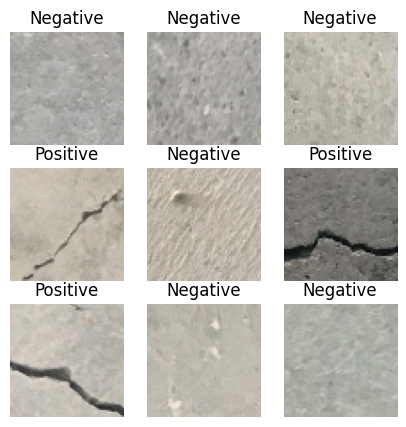

In [6]:
import matplotlib.pyplot as plt

def show_preview_img(dataset):
    plt.figure(figsize=(5, 5))

    # ambil batch 1
    for images, labels in dataset.take(1):

        # ambil 9 gambar pertama
        for i in range(9):
            plt.subplot(3, 3, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            
            if labels.numpy()[i][0] == 1:
                plt.title("Negative")
            else:
                plt.title("Positive")
                
            
            plt.axis("off")
            
show_preview_img(train_set)


# Preprocessing Images

## Sesuaikan Kecerahan Images

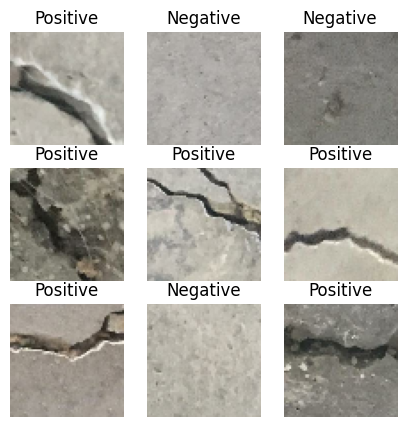

In [7]:
def augment(x, y):
    image = tf.image.random_brightness(x, max_delta=0.5)
    return image, y

augmented_train_set = train_set.map(augment)
augmented_test_set = test_set.map(augment)

show_preview_img(augmented_train_set)

## Sesuaikan Kejelasan Images
Memperjelas bayangan retakan

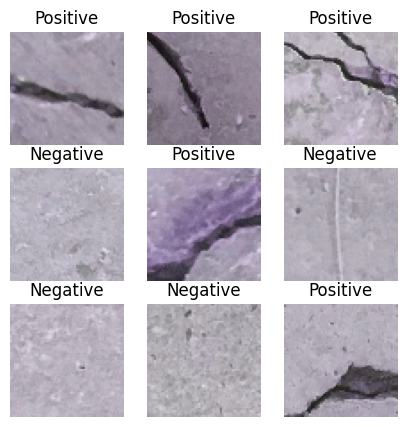

In [8]:
def hue(x, y):
    image = tf.image.random_hue(x, max_delta=0.5)
    return image, y
    
hued_train_set = augmented_train_set.map(hue)
hued_test_set = augmented_test_set.map(hue)

show_preview_img(hued_train_set)

## Saturasi Images
Pekatkan warna gambar

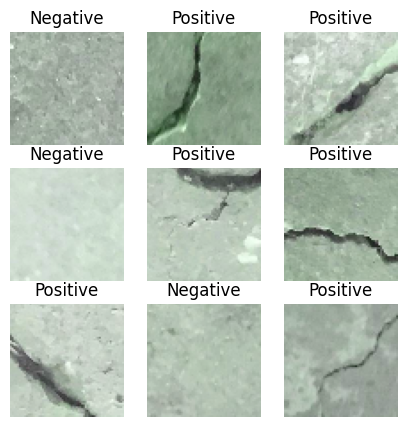

In [9]:
def saturate(x, y):
    image = tf.image.random_saturation(x, 0.5, 1.5)
    return image, y

saturated_train_set = hued_train_set.map(saturate)
saturated_test_set = hued_test_set.map(saturate)

show_preview_img(saturated_train_set)

## Kontraskan Images
Mempertajam gambar

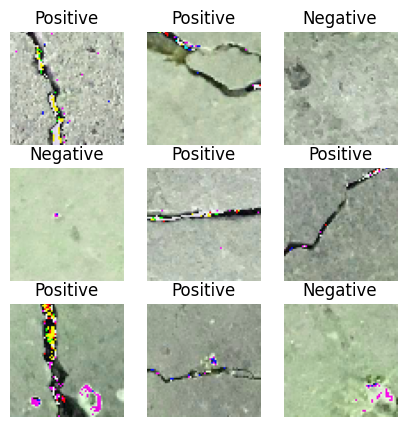

In [10]:
def contrast(x, y):
    image = tf.image.random_contrast(x, 0.7, 1.5)
    return image, y

contrasted_train_set = saturated_train_set.map(contrast)
contrasted_test_set = saturated_test_set.map(contrast)

show_preview_img(contrasted_train_set)

## Grayscale Images

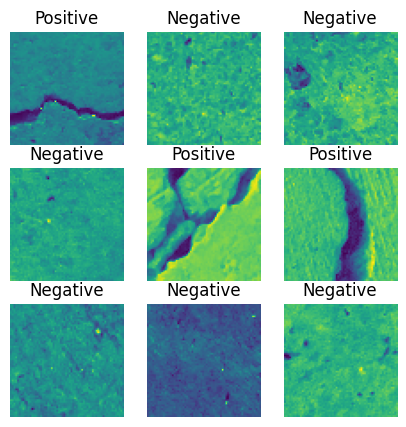

In [11]:
def grayscale(x, y):
    image = tf.image.rgb_to_grayscale(x)
    return image, y

grayscaled_train_set = contrasted_train_set.map(grayscale)
grayscaled_test_set = contrasted_test_set.map(grayscale)

show_preview_img(grayscaled_train_set)

# Modelling

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Input((64, 64, 1)),
    
    tf.keras.layers.Conv2D(16, 3, activation="relu"),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(2, activation="sigmoid" )
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dense (Dense)               (None, 2)                 57602     
                                                                 
Total params: 62,402
Trainable params: 62,402
Non-trainable params: 0
____________________________________________________

## Optimalisasi Model

In [13]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

## Callback

In [14]:
class myCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("loss") < 0.1:
            self.model.stop_training = True


cb = myCallBack()

# Fitting Model

In [15]:
history = model.fit(
    grayscaled_train_set,
    epochs=10,
    verbose=1,
    validation_data=grayscaled_test_set,
    callbacks=cb
)

Epoch 1/10
1000/1000 [==============================] - 111s 110ms/step - loss: 0.6302 - accuracy: 0.9595 - val_loss: 0.0856 - val_accuracy: 0.9825
Epoch 2/10
1000/1000 [==============================] - 162s 162ms/step - loss: 0.1106 - accuracy: 0.9714 - val_loss: 0.0863 - val_accuracy: 0.9718
Epoch 3/10
1000/1000 [==============================] - 157s 157ms/step - loss: 0.1139 - accuracy: 0.9711 - val_loss: 0.2214 - val_accuracy: 0.9589
Epoch 4/10
1000/1000 [==============================] - 160s 159ms/step - loss: 0.1735 - accuracy: 0.9578 - val_loss: 0.2832 - val_accuracy: 0.9419
Epoch 5/10
1000/1000 [==============================] - 155s 155ms/step - loss: 0.2224 - accuracy: 0.9513 - val_loss: 0.1961 - val_accuracy: 0.9465
Epoch 6/10
1000/1000 [==============================] - 5943s 6s/step - loss: 0.1500 - accuracy: 0.9644 - val_loss: 0.1411 - val_accuracy: 0.9730
Epoch 7/10
1000/1000 [==============================] - 84s 84ms/step - loss: 0.1245 - accuracy: 0.9682 - val_loss

## Visualisasi Akurasi dan Loss